# Task 1

---

## Web scraping and analysis

This Jupyter notebook includes some code to get you started with web scraping. We will use a package called `BeautifulSoup` to collect the data from the web. Once you've collected your data and saved it into a local `.csv` file you should start with your analysis.

### Scraping data from Skytrax

If you visit [https://www.airlinequality.com] you can see that there is a lot of data there. For this task, we are only interested in reviews related to British Airways and the Airline itself.

If you navigate to this link: [https://www.airlinequality.com/airline-reviews/british-airways] you will see this data. Now, we can use `Python` and `BeautifulSoup` to collect all the links to the reviews and then to collect the text data on each of the individual review links.

In [18]:
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

reviews = []

# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
    
    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews


In [3]:
df = pd.DataFrame()
df["reviews"] = reviews
df.head()

,reviews
0,✅ Trip Verified | Organised boarding process. ...
1,✅ Trip Verified | Outward journey BA245 Londo...
2,✅ Trip Verified | Check in agent at LHR was ve...
3,✅ Trip Verified | Very disappointing. I book ...
4,✅ Trip Verified | Excellent service both on th...


In [4]:
df.to_csv("BA_reviews.csv")

Congratulations! Now you have your dataset for this task! The loops above collected 1000 reviews by iterating through the paginated pages on the website. However, if you want to collect more data, try increasing the number of pages!

 The next thing that you should do is clean this data to remove any unnecessary text from each of the rows. For example, "✅ Trip Verified" can be removed from each row if it exists, as it's not relevant to what we want to investigate.

In [5]:
#Understand the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   reviews  1000 non-null   object
dtypes: object(1)
memory usage: 7.9+ KB


In [6]:
#Checking the duplicates columns
df.duplicated().sum()
#No duplicated values in the data set

0

In [7]:
#We remove some specially charateristic
import re
import nltk
from nltk.stem  import WordNetLemmatizer


In [8]:
def text_process(df):
    lematizer=WordNetLemmatizer()
    for i in range(0,len(df)):
        review=re.sub('[^a-zA-Z]', ' ',df)
        review=review.lower()
        review=review.split()
        review=[lematizer.lemmatize(word) for word in review]
        review=' '.join(review)
        return review

In [9]:
df['reviews']=df['reviews'].apply(text_process)

In [10]:
df.head()

,reviews
0,trip verified organised boarding process reall...
1,trip verified outward journey ba london to bue...
2,trip verified check in agent at lhr wa very he...
3,trip verified very disappointing i book ba so ...
4,trip verified excellent service both on the gr...


In [11]:
# import sentiment intensity analyzer
from nltk.sentiment.vader import  SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
# create sentiment intensity analyzer object

analyzer=SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [12]:
#Create a function for decicader a sentiment is positive and negative
def get_score(score):
    if score<0.0:
        return 'negative'
    elif score==0.0:
        return 'neutral'
    else:
        return 'Positive'

In [13]:
#Apply the SentimentIntensityAnalyzer
ds_score=[]
for value in df['reviews'].values:
    ds_score.append(analyzer.polarity_scores(value)['compound'])
df['Sentiment']=ds_score
df.head()

,reviews,Sentiment
0,trip verified organised boarding process reall...,0.9371
1,trip verified outward journey ba london to bue...,-0.7033
2,trip verified check in agent at lhr wa very he...,0.3774
3,trip verified very disappointing i book ba so ...,0.6432
4,trip verified excellent service both on the gr...,0.7962


In [14]:
df['Sentiment']=df['Sentiment'].apply(get_score)
df.head()

,reviews,Sentiment
0,trip verified organised boarding process reall...,Positive
1,trip verified outward journey ba london to bue...,negative
2,trip verified check in agent at lhr wa very he...,Positive
3,trip verified very disappointing i book ba so ...,Positive
4,trip verified excellent service both on the gr...,Positive


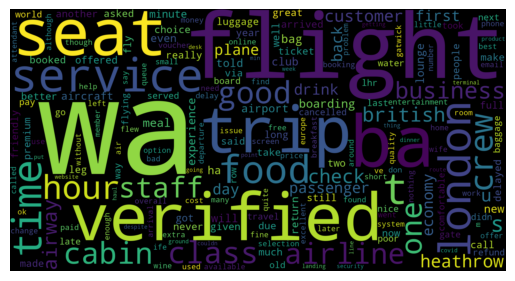

In [19]:
from wordcloud import WordCloud
text = " ".join(i for i in df['reviews'])
word_cloud1 = WordCloud(collocations = False, background_color = 'black',width = 2048, height = 1080).generate(text)
plt.imshow(word_cloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

In [20]:
df['Sentiment'].value_counts()

Positive    566
negative    431
neutral       3
Name: Sentiment, dtype: int64

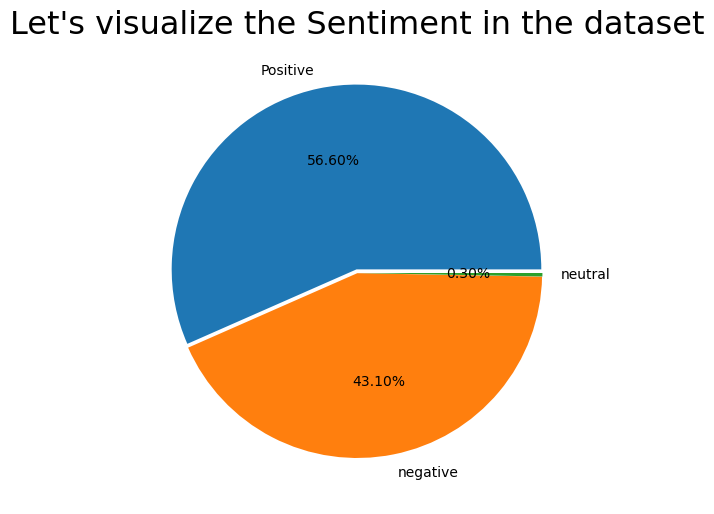

In [21]:
#Let's visualize the Sentiment
plt.figure(figsize=(8,6))
plt.pie(df['Sentiment'].value_counts(),explode=[0.02,0.001,0.002],labels=['Positive','negative','neutral'],autopct='%1.2f%%')
plt.title("Let's visualize the Sentiment in the dataset",fontsize=23)
plt.show()

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
#Divided the data into X and y varibles after that we convert the reviwes into vectors
X=df['reviews'].values
y=df['Sentiment']
vector=TfidfVectorizer()
vector.fit(X)
X=vector.fit_transform(X)


# Machine Learning Modeling

In [23]:
#import the libreries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25)


The modelLogisticRegression() socre is 80.40
The model LogisticRegression() socre is 97.33
-----------------------------------------------------------------
Classification report               precision    recall  f1-score   support

    Positive       0.85      0.82      0.83       146
    negative       0.75      0.79      0.77       103
     neutral       0.00      0.00      0.00         1

    accuracy                           0.80       250
   macro avg       0.53      0.54      0.53       250
weighted avg       0.80      0.80      0.80       250

[[120  26   0]
 [ 22  81   0]
 [  0   1   0]]
None


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


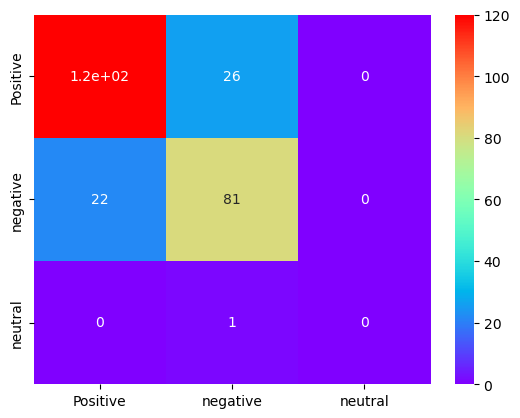

In [28]:
#Create a function for modeling
def model_score(model,X_train,X_test,y_train,y_test):
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    print(f'The model{model} socre is {model.score(X_test,y_test)*100:.2f}')
    print(f'The model {model} socre is {model.score(X_train,y_train)*100:.2f}')
    print('-----------------------------------------------------------------')
    print('Classification report',classification_report(y_test,y_pred))
    matrix=confusion_matrix(y_test,y_pred)
    print(matrix)
    sns.heatmap(matrix,annot=True,cmap='rainbow',xticklabels=['Positive','negative','neutral'],yticklabels=['Positive','negative','neutral'])
#Apply the linear Regression model
logistic=LogisticRegression()
print(model_score(logistic,X_train,X_test,y_train,y_test))

The modelRandomForestClassifier() socre is 76.40
The model RandomForestClassifier() socre is 100.00
-----------------------------------------------------------------
Classification report               precision    recall  f1-score   support

    Positive       0.80      0.80      0.80       146
    negative       0.71      0.72      0.71       103
     neutral       0.00      0.00      0.00         1

    accuracy                           0.76       250
   macro avg       0.50      0.51      0.51       250
weighted avg       0.76      0.76      0.76       250

[[117  29   0]
 [ 29  74   0]
 [  0   1   0]]
None


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


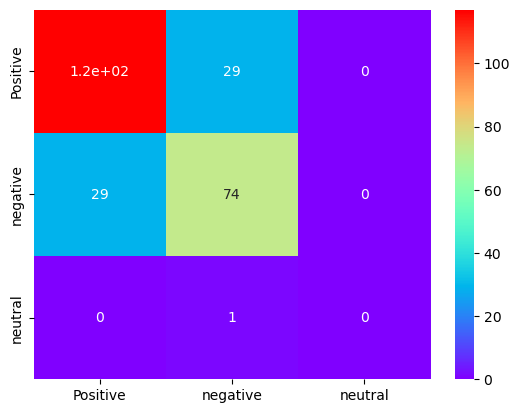

In [29]:
#Apply the RandomForest Classifier model
random=RandomForestClassifier()
print(model_score(random,X_train,X_test,y_train,y_test))

The modelDecisionTreeClassifier() socre is 65.20
The model DecisionTreeClassifier() socre is 100.00
-----------------------------------------------------------------
Classification report               precision    recall  f1-score   support

    Positive       0.72      0.66      0.69       146
    negative       0.57      0.65      0.61       103
     neutral       0.00      0.00      0.00         1

    accuracy                           0.65       250
   macro avg       0.43      0.44      0.43       250
weighted avg       0.66      0.65      0.65       250

[[96 50  0]
 [36 67  0]
 [ 1  0  0]]
None


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


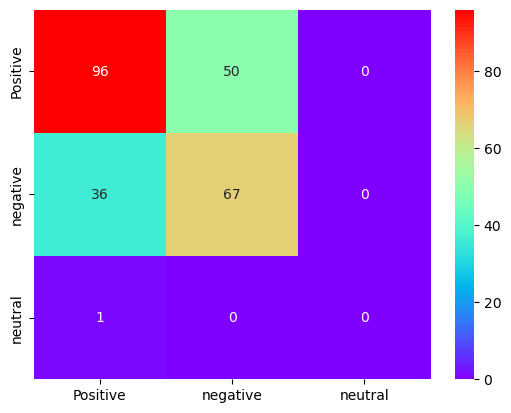

In [30]:
#Apply the DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
tree=DecisionTreeClassifier()
print(model_score(tree,X_train,X_test,y_train,y_test))